This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray IRIS backend

In this example, we read IRIS (sigmet) data files using the wradlib `iris` xarray backend.

In [1]:
import glob
import gzip
import io
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

## Load IRIS Volume Data

In [2]:
fpath = 'sigmet/SUR210819000227.RAWKPJV'
f = wrl.util.get_wradlib_data_file(fpath)
vol = wrl.io.open_iris_dataset(f, reindex_angle=False)

### Inspect RadarVolume

In [3]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 1)
Elevation(s): (0.5)

### Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [4]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 1)
Coordinates:
    time                 datetime64[ns] 2021-08-19T00:02:27.432000
    longitude            float64 25.52
    altitude             float64 157.0
    sweep_mode           <U20 'azimuth_surveillance'
    latitude             float64 58.48
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2021-08-19T00:02:28Z'
    time_coverage_end    <U20 '2021-08-19T00:02:49Z'
    sweep_group_name     (sweep) <U7 'sweep_0'
    sweep_fixed_angle    (sweep) float64 0.5
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.5

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [5]:
display(vol[0])

<xarray.Dataset>
Dimensions:     (azimuth: 359, range: 833)
Coordinates:
  * azimuth     (azimuth) float32 0.03021 1.035 2.054 ... 357.0 358.0 359.0
    elevation   (azimuth) float32 ...
    rtime       (azimuth) datetime64[ns] 2021-08-19T00:02:31.104000 ... 2021-...
    time        datetime64[ns] 2021-08-19T00:02:27.432000
  * range       (range) float32 150.0 450.0 750.0 ... 2.494e+05 2.498e+05
    longitude   float64 ...
    latitude    float64 ...
    altitude    float64 ...
    sweep_mode  <U20 ...
Data variables:
    DB_XHDR     (azimuth, range) object ...
    DBTH        (azimuth, range) float32 ...
    DBZH        (azimuth, range) float32 ...
    VRADH       (azimuth, range) float32 ...
    WRADH       (azimuth, range) float32 ...
    ZDR         (azimuth, range) float32 ...
    KDP         (azimuth, range) float32 ...
    RHOHV       (azimuth, range) float32 ...
    SQIH        (azimuth, range) float32 ...
    PHIDP       (azimuth, range) float32 ...
    DB_HCLASS2  (azimuth, range) int16 ...
    SNRH        (azimuth, range) float32 ...
Attributes:
    fixed_angle:  0.5

### Goereferencing

In [6]:
swp = vol[0].copy().pipe(wrl.georef.georeference_dataset)

### Plotting

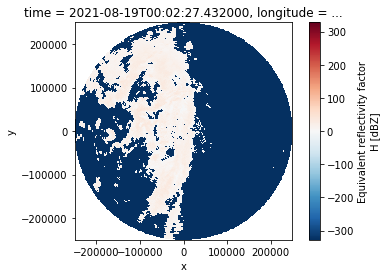

In [7]:
swp.DBZH.plot.pcolormesh(x='x', y='y')
pl.gca().set_aspect('equal')

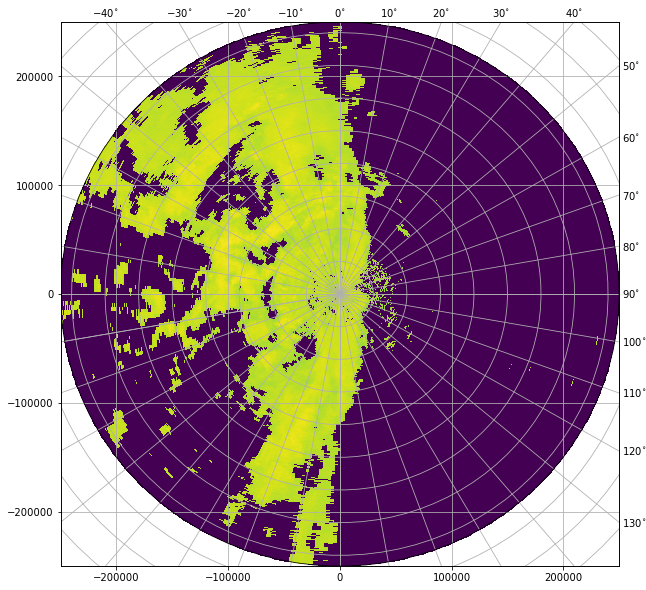

In [8]:
fig = pl.figure(figsize=(10,10))
swp.DBZH.wradlib.plot_ppi(proj='cg', fig=fig)

In [9]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                                      central_longitude=swp.longitude.values)

< GeoAxes: +proj=aeqd +ellps=WGS84 +lon_0=25.518660116940737 +lat_0=58.48231002688408 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >


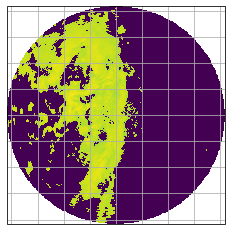

In [10]:
map_proj = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                                      central_longitude=swp.longitude.values)
pm = swp.DBZH.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

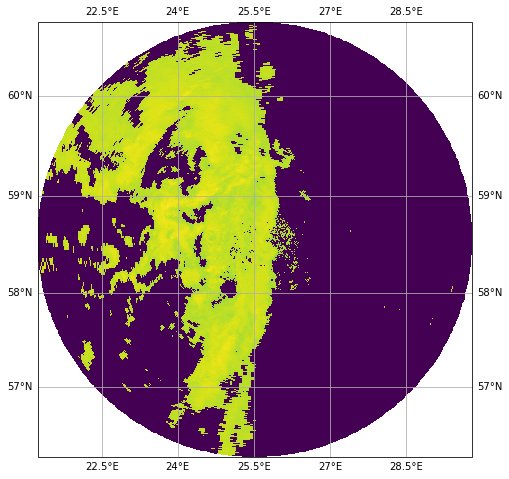

In [11]:
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
pm = swp.DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

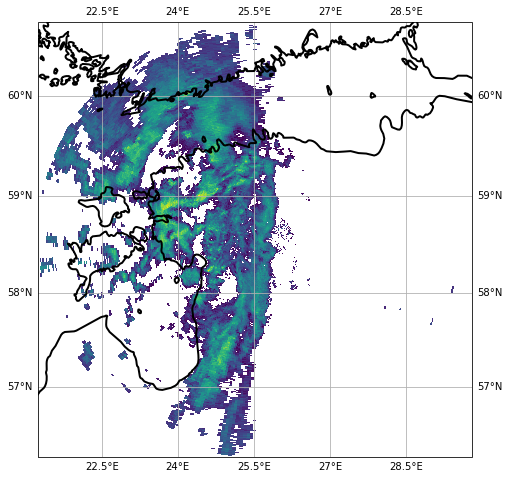

In [12]:
import cartopy.feature as cfeature
def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(category='physical',
                                           name='coastline',
                                           scale='10m',
                                           facecolor='none')
    ax.add_feature(borders, edgecolor='black', lw=2, zorder=4)

map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)

DBZH = swp.DBZH
pm = DBZH.where(DBZH > 0).wradlib.plot_ppi(ax=ax)
plot_borders(ax)
ax.gridlines(draw_labels=True)

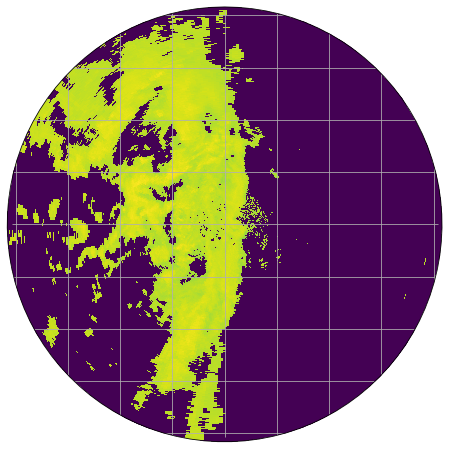

In [13]:
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

map_proj = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                                     central_longitude=swp.longitude.values,
                                    )
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
ax.set_boundary(circle, transform=ax.transAxes)

pm = swp.DBZH.wradlib.plot_ppi(proj=map_proj, ax=ax)
ax = pl.gca()
ax.gridlines(crs=map_proj)

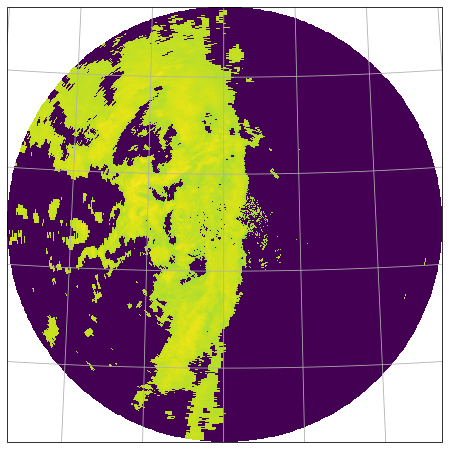

In [14]:
fig = pl.figure(figsize=(10, 8))
proj=ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                               central_longitude=swp.longitude.values)
ax = fig.add_subplot(111, projection=proj)
pm = swp.DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines()

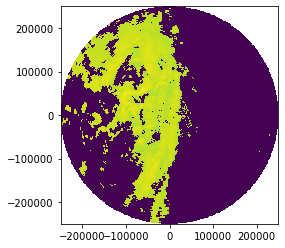

In [15]:
swp.DBZH.wradlib.plot_ppi()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset.

In [16]:
display(swp.DBZH)

<xarray.DataArray 'DBZH' (azimuth: 359, range: 833)>
array([[-327.68, -327.68, -327.68, ..., -327.68, -327.68, -327.68],
       [-327.68,    3.39,    6.45, ..., -327.68, -327.68, -327.68],
       [  -8.86,    5.25,    8.58, ..., -327.68, -327.68, -327.68],
       ...,
       [-327.68, -327.68, -327.68, ..., -327.68, -327.68, -327.68],
       [-327.68,    4.75,   10.95, ..., -327.68, -327.68, -327.68],
       [-327.68, -327.68,    4.94, ..., -327.68, -327.68, -327.68]])
Coordinates: (12/15)
  * azimuth     (azimuth) float32 0.03021 1.035 2.054 ... 357.0 358.0 359.0
    elevation   (azimuth) float64 0.5054 0.5054 0.5054 ... 0.5054 0.5054 0.5054
    rtime       (azimuth) datetime64[ns] 2021-08-19T00:02:31.104000 ... 2021-...
    time        datetime64[ns] 2021-08-19T00:02:27.432000
  * range       (range) float32 150.0 450.0 750.0 ... 2.494e+05 2.498e+05
    longitude   float64 25.52
    ...          ...
    x           (azimuth, range) float64 0.0791 0.2373 ... -4.206e+03 -4.211e+03
    y           (azimuth, range) float64 150.0 450.0 ... 2.493e+05 2.496e+05
    z           (azimuth, range) float64 158.3 161.0 ... 6.023e+03 6.034e+03
    gr          (azimuth, range) float64 150.0 450.0 ... 2.493e+05 2.496e+05
    rays        (azimuth, range) float32 0.03021 0.03021 0.03021 ... 359.0 359.0
    bins        (azimuth, range) float32 150.0 450.0 ... 2.494e+05 2.498e+05
Attributes:
    standard_name:  radar_equivalent_reflectivity_factor_h
    units:          dBZ
    long_name:      Equivalent reflectivity factor H

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('rtime')` method, which sorts the radials by time.

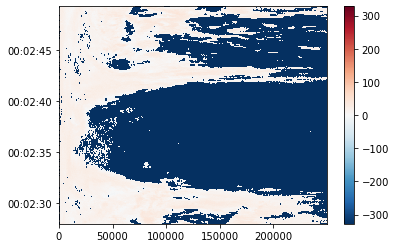

In [17]:
swp.DBZH.sortby('rtime').plot(x="range", y="rtime", add_labels=False)

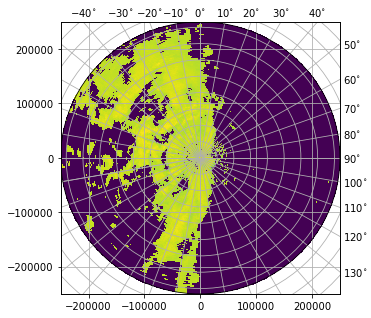

In [18]:
fig = pl.figure(figsize=(5,5))
pm = swp.DBZH.wradlib.plot_ppi(proj={'latmin': 3e3}, fig=fig)

### Mask some values

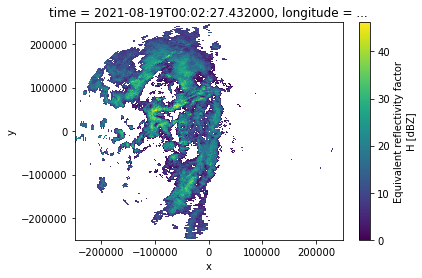

In [19]:
dbzh = swp['DBZH'].where(swp['DBZH'] >= 0)
dbzh.plot(x="x", y="y")

In [20]:
vol[0]

<xarray.Dataset>
Dimensions:     (azimuth: 359, range: 833)
Coordinates:
  * azimuth     (azimuth) float32 0.03021 1.035 2.054 ... 357.0 358.0 359.0
    elevation   (azimuth) float64 0.5054 0.5054 0.5054 ... 0.5054 0.5054 0.5054
    rtime       (azimuth) datetime64[ns] 2021-08-19T00:02:31.104000 ... 2021-...
    time        datetime64[ns] 2021-08-19T00:02:27.432000
  * range       (range) float32 150.0 450.0 750.0 ... 2.494e+05 2.498e+05
    longitude   float64 25.52
    latitude    float64 58.48
    altitude    float64 157.0
    sweep_mode  <U20 'azimuth_surveillance'
Data variables:
    DB_XHDR     (azimuth, range) object ...
    DBTH        (azimuth, range) float32 ...
    DBZH        (azimuth, range) float32 ...
    VRADH       (azimuth, range) float32 ...
    WRADH       (azimuth, range) float32 ...
    ZDR         (azimuth, range) float32 ...
    KDP         (azimuth, range) float32 ...
    RHOHV       (azimuth, range) float32 ...
    SQIH        (azimuth, range) float32 ...
    PHIDP       (azimuth, range) float32 ...
    DB_HCLASS2  (azimuth, range) int16 ...
    SNRH        (azimuth, range) float32 ...
Attributes:
    fixed_angle:  0.5

### Export to ODIM and CfRadial2

Need to remove DB_XHDR since it can't be represented as ODIM/CfRadial2 moment.

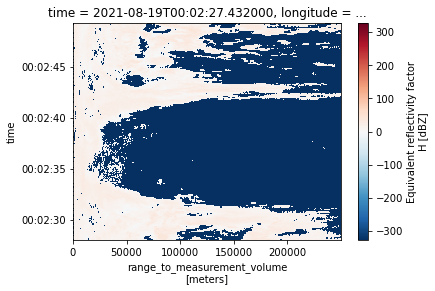

In [21]:
vol[0] = vol[0].drop("DB_XHDR", errors="ignore")
vol[0].DBZH.sortby("rtime").plot(y="rtime")

In [22]:
vol.to_odim('iris_as_odim.h5')
vol.to_cfradial2('iris_as_cfradial2.nc')

### Import again

<xarray.Dataset>
Dimensions:              (sweep: 1)
Coordinates:
    time                 datetime64[ns] 2021-08-19T00:02:28
    sweep_mode           <U20 'azimuth_surveillance'
    longitude            float64 25.52
    altitude             float64 157.0
    latitude             float64 58.48
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2021-08-19T00:02:28Z'
    time_coverage_end    <U20 '2021-08-19T00:02:49Z'
    sweep_group_name     (sweep) <U7 'sweep_0'
    sweep_fixed_angle    (sweep) float64 0.5
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.5

<xarray.Dataset>
Dimensions:     (azimuth: 359, range: 833)
Coordinates:
  * azimuth     (azimuth) float32 0.03021 1.035 2.054 ... 357.0 358.0 359.0
    elevation   (azimuth) float64 ...
    rtime       (azimuth) datetime64[ns] 2021-08-19T00:02:31.104000 ... 2021-...
  * range       (range) float32 150.0 450.0 750.0 ... 2.494e+05 2.498e+05
    time        datetime64[ns] 2021-08-19T00:02:28
    sweep_mode  <U20 ...
    longitude   float64 ...
    latitude    float64 ...
    altitude    float64 ...
Data variables:
    DBTH        (azimuth, range) float32 ...
    SNRH        (azimuth, range) float32 ...
    DBZH        (azimuth, range) float32 ...
    VRADH       (azimuth, range) float32 ...
    WRADH       (azimuth, range) float32 ...
    ZDR         (azimuth, range) float32 ...
    KDP         (azimuth, range) float32 ...
    RHOHV       (azimuth, range) float32 ...
    SQIH        (azimuth, range) float32 ...
    PHIDP       (azimuth, range) float32 ...
Attributes:
    fixed_angle:  0.5

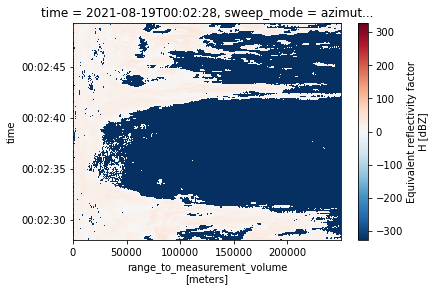

In [23]:
vola = wrl.io.open_odim_dataset('iris_as_odim.h5', reindex_angle=False, keep_elevation=True)
display(vola.root)
display(vola[0])
vola[0].DBZH.sortby("rtime").plot(y="rtime")

<xarray.Dataset>
Dimensions:              (sweep: 1)
Coordinates:
    longitude            float64 25.52
    altitude             float64 157.0
    sweep_mode           <U20 'azimuth_surveillance'
    time                 datetime64[ns] 2021-08-19T00:02:28
    latitude             float64 58.48
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2021-08-19T00:02:28Z'
    time_coverage_end    <U20 '2021-08-19T00:02:49Z'
    sweep_group_name     (sweep) <U7 'sweep_0'
    sweep_fixed_angle    (sweep) float64 0.5
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.5

<xarray.Dataset>
Dimensions:     (azimuth: 359, range: 833)
Coordinates:
  * azimuth     (azimuth) float32 0.03021 1.035 2.054 ... 357.0 358.0 359.0
    elevation   (azimuth) float32 ...
    rtime       (azimuth) datetime64[ns] 2021-08-19T00:02:31.104000 ... 2021-...
  * range       (range) float32 150.0 450.0 750.0 ... 2.494e+05 2.498e+05
    longitude   float64 ...
    latitude    float64 ...
    altitude    float64 ...
    sweep_mode  <U20 ...
    time        datetime64[ns] 2021-08-19T00:02:28
Data variables:
    DBTH        (azimuth, range) float32 ...
    DBZH        (azimuth, range) float32 ...
    VRADH       (azimuth, range) float32 ...
    WRADH       (azimuth, range) float32 ...
    ZDR         (azimuth, range) float32 ...
    KDP         (azimuth, range) float32 ...
    RHOHV       (azimuth, range) float32 ...
    SQIH        (azimuth, range) float32 ...
    PHIDP       (azimuth, range) float32 ...
    DB_HCLASS2  (azimuth, range) int16 ...
    SNRH        (azimuth, range) float32 ...
Attributes:
    fixed_angle:  0.5

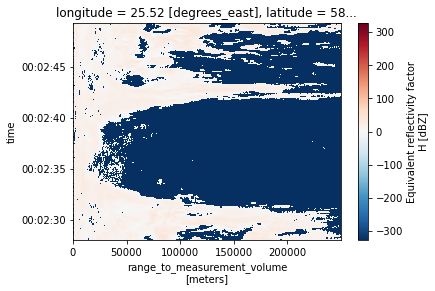

In [24]:
volb = wrl.io.open_cfradial2_dataset('iris_as_cfradial2.nc')
display(volb.root)
display(volb[0])
volb[0].DBZH.sortby("rtime").plot(y="rtime")

### Check equality

We have to drop the time variable when checking equality since IRIS has millisecond resolution.

In [25]:
xr.testing.assert_allclose(vol.root.drop("time"), vola.root.drop("time"))
xr.testing.assert_allclose(vol[0].drop(["rtime", "time", "DB_HCLASS2"]), vola[0].drop(["rtime", "time"]))
xr.testing.assert_allclose(vol.root.drop("time"), volb.root.drop("time"))
xr.testing.assert_allclose(vol[0].drop("time"), volb[0].drop("time"))
xr.testing.assert_allclose(vola.root, volb.root)
xr.testing.assert_allclose(vola[0].drop("rtime"), volb[0].drop(["rtime", "DB_HCLASS2"]))

## More Iris loading mechanisms

### Use `xr.open_dataset` to retrieve explicit group

In [26]:
swp = xr.open_dataset(f, engine="iris", group=1, backend_kwargs=dict(reindex_angle=False))
display(swp)

<xarray.Dataset>
Dimensions:     (azimuth: 359, range: 833)
Coordinates:
  * azimuth     (azimuth) float32 0.03021 1.035 2.054 ... 357.0 358.0 359.0
    elevation   (azimuth) float32 ...
    rtime       (azimuth) datetime64[ns] ...
    time        datetime64[ns] ...
  * range       (range) float32 150.0 450.0 750.0 ... 2.494e+05 2.498e+05
    longitude   float64 ...
    latitude    float64 ...
    altitude    float64 ...
    sweep_mode  <U20 ...
Data variables:
    DB_XHDR     (azimuth, range) object ...
    DBTH        (azimuth, range) float32 ...
    DBZH        (azimuth, range) float32 ...
    VRADH       (azimuth, range) float32 ...
    WRADH       (azimuth, range) float32 ...
    ZDR         (azimuth, range) float32 ...
    KDP         (azimuth, range) float32 ...
    RHOHV       (azimuth, range) float32 ...
    SQIH        (azimuth, range) float32 ...
    PHIDP       (azimuth, range) float32 ...
    DB_HCLASS2  (azimuth, range) int16 ...
    SNRH        (azimuth, range) float32 ...
Attributes:
    fixed_angle:  0.5